In [99]:
!pip install pydriller scipy scikit-learn pandas matplotlib seaborn tqdm sentence-transformers

In [100]:
!git clone https://github.com/laude-institute/terminal-bench.git

fatal: destination path 'terminal-bench' already exists and is not an empty directory.


In [101]:
import os
# --- FIX 1: STOP PARALLELISM WARNING ---
# This must be set BEFORE importing sentence_transformers or transformers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import subprocess
import re
import math
import warnings
from io import BytesIO
from datetime import datetime

# Optional: Semantic Analysis
try:
    from sentence_transformers import SentenceTransformer
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    SEMANTIC_AVAILABLE = True
except ImportError:
    SEMANTIC_AVAILABLE = False
    print("Warning: sentence-transformers not installed. Semantic features will be skipped.")

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")


In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import subprocess
import re
import math
import warnings
from datetime import datetime
import os

# Disable tokenizers parallelism to prevent deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Optional: Semantic Analysis
try:
    from sentence_transformers import SentenceTransformer
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    SEMANTIC_AVAILABLE = True
except ImportError:
    SEMANTIC_AVAILABLE = False

warnings.filterwarnings('ignore')

# ==========================================
# 0. REPOSITORY MANAGEMENT
# ==========================================

def ensure_repo_exists(repo_path, repo_url):
    """
    Check if repository exists, clone it if not.
    
    Args:
        repo_path: Local path where repo should exist
        repo_url: GitHub URL to clone from
    """
    if not os.path.exists(repo_path):
        print(f"Repository not found at {repo_path}")
        print(f"Cloning from {repo_url}...")
        try:
            subprocess.run(['git', 'clone', repo_url, repo_path], 
                         check=True, capture_output=True)
            print(f"✓ Successfully cloned to {repo_path}")
        except subprocess.CalledProcessError as e:
            print(f"✗ Failed to clone: {e.stderr.decode()}")
            return False
    else:
        print(f"✓ Repository found at {repo_path}")
    return True

# ==========================================
# 1. CORE UTILITIES
# ==========================================

def calculate_entropy(text):
    if not text: return 0
    counts = Counter(text)
    length = len(text)
    return -sum((count / length) * math.log2(count / length) for count in counts.values())

def dump_git_log(repo_path, start_ref="master", n_commits=None, out_file="git_log.txt"):
    # Check if repo exists
    if not os.path.exists(repo_path):
        raise FileNotFoundError(f"Repository not found at {repo_path}. Please clone it first or use ensure_repo_exists().")
    
    cmd = [
        "git", "-C", repo_path, "log", start_ref,
        "--no-renames", "--date=iso-strict",
        # FIXED: Added %ae (email) and %cd (committer date) back for feature extraction
        "--pretty=format:__COMMIT__%h|%an|%ae|%ad|%cd|%s",
        "--numstat" 
    ]
    if n_commits: cmd.extend(["-n", str(n_commits)])

    with open(out_file, "wb") as f:
        subprocess.run(cmd, stdout=f, stderr=subprocess.PIPE, check=True)
    return out_file

def parse_git_log_file(log_path):
    with open(log_path, "r", encoding="utf-8", errors="replace") as f:
        lines = f.readlines()
    
    data = []
    current_commit = None
    
    # State tracking
    stats = {
        'lines_added': 0, 'lines_deleted': 0, 
        'test_files': 0, 'src_files': 0, 'doc_files': 0,
        'sensitive_files': 0 
    }
    
    for line in tqdm(lines, desc="Parsing Log"):
        line = line.strip()
        
        if line.startswith("__COMMIT__"):
            # 1. Save Previous Commit
            if current_commit:
                total_files = stats['test_files'] + stats['src_files'] + stats['doc_files']
                # Avoid division by zero
                safe_total = total_files if total_files > 0 else 1
                
                current_commit.update({
                    # Map to the keys expected by the Anomaly Detector
                    'lines_inserted': stats['lines_added'],
                    'lines_deleted': stats['lines_deleted'],
                    'files_changed': total_files,
                    'file_count': total_files, # Alias for consistency
                    
                    # Security Features
                    'test_ratio': stats['test_files'] / safe_total,
                    'sensitive_ratio': stats['sensitive_files'] / safe_total,
                })
                data.append(current_commit)

            # 2. Start New Commit
            parts = line.split("|")
            try:
                # Parse: %h|%an|%ae|%ad|%cd|%s
                c_hash = parts[0].replace("__COMMIT__", "")
                c_author = parts[1]
                c_email = parts[2]
                c_ad_str = parts[3]
                c_cd_str = parts[4]
                c_msg = "|".join(parts[5:])

                # Dates & Latency
                a_dt = datetime.fromisoformat(c_ad_str)
                c_dt = datetime.fromisoformat(c_cd_str)
                latency = (c_dt - a_dt).total_seconds()

                # Holiday Check
                is_holiday = 1 if (a_dt.month == 12 and a_dt.day >= 24) or (a_dt.month == 1 and a_dt.day == 1) else 0
                
                current_commit = {
                    'hash': c_hash,
                    'author': c_author,
                    'email': c_email,
                    'author_date': a_dt,
                    'hour_of_day': a_dt.hour,   # REQUIRED key
                    'day_of_week': a_dt.weekday(),
                    'merge_latency_sec': latency, # REQUIRED key
                    'is_holiday': is_holiday,
                    'msg_length': len(c_msg),     # REQUIRED key
                    'msg_entropy': calculate_entropy(c_msg), # REQUIRED key
                    'msg_content': c_msg
                }
                # Reset stats
                stats = {'lines_added': 0, 'lines_deleted': 0, 'test_files': 0, 'src_files': 0, 'doc_files': 0, 'sensitive_files': 0}
            except Exception as e:
                current_commit = None
                continue
        
        elif current_commit and line:
            # Parse numstat: "10  5   src/file.c"
            parts = line.split("\t")
            if len(parts) == 3:
                added, deleted, filepath = parts
                
                if added == '-': added = 0
                if deleted == '-': deleted = 0
                
                stats['lines_added'] += int(added)
                stats['lines_deleted'] += int(deleted)

                # Classify File Type
                if "test" in filepath.lower() or filepath.endswith(".t"):
                    stats['test_files'] += 1
                elif filepath.endswith((".c", ".h", ".cpp", ".py", ".go", ".js", ".ts")):
                    stats['src_files'] += 1
                elif filepath.endswith((".md", ".txt", ".html")):
                    stats['doc_files'] += 1
                
                if "ssl/" in filepath or "crypto/" in filepath:
                    stats['sensitive_files'] += 1

    # Don't forget the very last commit in the file!
    if current_commit:
        total_files = stats['test_files'] + stats['src_files'] + stats['doc_files']
        safe_total = total_files if total_files > 0 else 1
        current_commit.update({
            'lines_inserted': stats['lines_added'],
            'lines_deleted': stats['lines_deleted'],
            'files_changed': total_files,
            'file_count': total_files,
            'test_ratio': stats['test_files'] / safe_total,
            'sensitive_ratio': stats['sensitive_files'] / safe_total,
        })
        data.append(current_commit)

    df = pd.DataFrame(data)
    
    if df.empty: return df

    # Final Feature Engineering: Churn Ratio
    df['total_change'] = df['lines_inserted'] + df['lines_deleted']
    df['churn_ratio'] = df.apply(
        lambda row: row['total_change'] / row['files_changed'] if row['files_changed'] > 0 else 0, 
        axis=1
    )
    
    return df

# ==========================================
# 2. ML & ANALYSIS FUNCTIONS
# ==========================================

def detect_statistical_anomalies(df, contamination=0.05):
    if len(df) < 50:
        contamination = 0.1 

    # These keys MUST exist in the parsed dataframe
    features = [
        'hour_of_day', 
        'lines_inserted', 
        'lines_deleted', 
        'msg_length', 
        'msg_entropy', 
        'churn_ratio', 
        'merge_latency_sec',
        # Security / Heartbleed Features
        'is_holiday',
        'test_ratio', 
        'sensitive_ratio',
        'files_changed'
    ]
    
    # Fill NAs
    X = df[features].fillna(0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = IsolationForest(contamination=contamination, random_state=42)
    df['anomaly_score'] = model.fit_predict(X_scaled)
    df['is_anomaly'] = df['anomaly_score'].apply(lambda x: True if x == -1 else False)
    
    return df

def detect_semantic_anomalies(df, repo_path):
    if not SEMANTIC_AVAILABLE or df.empty: return df

    suspects = df[df['is_anomaly'] == True].copy()
    if suspects.empty: 
        df['semantic_anomaly'] = False
        return df

    def get_diff(h):
        try:
            cmd = ["git", "-C", repo_path, "show", h, "--pretty=", "--minimal"]
            res = subprocess.run(cmd, capture_output=True, text=True, errors="replace")
            return res.stdout[:2000]
        except: return ""

    tqdm.pandas(desc="Analyzing Semantics")
    suspects['diff_content'] = suspects['hash'].progress_apply(lambda h: get_diff(h))
    
    combined_text = (suspects['msg_content'] + "\n" + suspects['diff_content']).tolist()
    embeddings = embedder.encode(combined_text)
    
    if len(embeddings) < 5:
        suspects['semantic_anomaly'] = True
    else:
        iso = IsolationForest(contamination=0.2, random_state=42)
        suspects['semantic_score'] = iso.fit_predict(embeddings)
        suspects['semantic_anomaly'] = suspects['semantic_score'] == -1
        
    df = df.merge(suspects[['hash', 'semantic_anomaly']], on='hash', how='left')
    df['semantic_anomaly'] = df['semantic_anomaly'].fillna(False)
    return df

# ==========================================
# 3. REQUESTED API FUNCTIONS
# ==========================================

def get_repo_anomaly_report(repo_path, n_commits=None, ref="master", verbose=True):
    log_file = dump_git_log(repo_path, start_ref=ref, n_commits=n_commits)
    if not log_file: return None
    
    df = parse_git_log_file(log_file)
    if df.empty: return None

    df = detect_statistical_anomalies(df)
    
    if verbose:
        df = detect_semantic_anomalies(df, repo_path)
        anomalies = df[df['is_anomaly'] == True]
        print(f"\n--- REPORT (Context: {len(df)} commits) ---")
        print(f"Detected {len(anomalies)} anomalies.")
        
    return df

def check_commit_is_anomaly(repo_path, commit_hash, n_commits=2000):
    print(f"Building context window: {n_commits} commits leading up to {commit_hash}...")
    
    df = get_repo_anomaly_report(repo_path, n_commits=n_commits, ref=commit_hash, verbose=False)
    
    if df is None or df.empty:
        print("Error: Could not retrieve history.")
        return

    target = df[df['hash'].str.startswith(commit_hash)]
    
    if target.empty:
        print(f"Critical Error: Commit {commit_hash} not found in the parsed log.")
        return

    row = target.iloc[0]
    
    print("\n" + "="*60)
    print(f"  ANOMALY CHECK: {row['hash']}")
    print("="*60)
    print(f"Author:   {row['author']} <{row['email']}>")
    print(f"Date:     {row['author_date']}")
    print(f"Message:  {row['msg_content']}")
    print("-" * 30)
    print(f"Stats:    +{row['lines_inserted']} / -{row['lines_deleted']} (Churn: {row['churn_ratio']:.2f})")
    print(f"Features: Holiday={row['is_holiday']} | TestRatio={row['test_ratio']:.2f} | SensitiveRatio={row['sensitive_ratio']:.2f}")
    print("-" * 30)
    
    if row['is_anomaly']:
        print("🔴 STATUS: ANOMALY DETECTED")
        print("   -> This commit deviates statistically from the previous history.")
    else:
        print("🟢 STATUS: NORMAL")
        print("   -> This commit fits the standard profile of this repo.")
        
    return row

# Case Study 1: OpenSSL "Heartbleed" (Holiday Anomaly)

The **Heartbleed bug** (CVE-2014-0160) was introduced on New Year's Eve 2011 and remained undetected for over 2 years, compromising millions of servers worldwide.

## Target Commit
- **Hash**: 4817504d06
- **Date**: December 31, 2011 (New Year's Eve)
- **Anomaly**: Committed on a holiday, high churn in sensitive SSL/crypto files, minimal testing

In [103]:
# Clone OpenSSL repository for Heartbleed analysis
!git clone https://github.com/openssl/openssl.git

fatal: destination path 'openssl' already exists and is not an empty directory.


✓ Repository found at ./openssl


Analyzing Semantics: 100%|██████████| 100/100 [00:04<00:00, 21.48it/s]



--- REPORT (Context: 2000 commits) ---
Detected 100 anomalies.


,hash,author,email,author_date,hour_of_day,day_of_week,merge_latency_sec,is_holiday,msg_length,msg_entropy,...,lines_deleted,files_changed,file_count,test_ratio,sensitive_ratio,total_change,churn_ratio,anomaly_score,is_anomaly,semantic_anomaly
21,ec11482675,David von Oheimb,David.von.Oheimb@siemens.com,2019-01-31 17:54:17+01:00,17,3,215104516.0,0,79,4.328107,...,174,13,13,0.769231,0.153846,343,26.384615,-1,True,False
87,f1d03c1ace,slontis,shane.lontis@oracle.com,2025-08-27 14:24:59+10:00,14,2,6763231.0,0,23,3.849224,...,451,11,11,0.272727,0.727273,1323,120.272727,-1,True,True
144,8752f7fc02,Tomas Mraz,tomas@openssl.org,2025-10-20 16:17:38+02:00,16,0,856880.0,0,55,3.912213,...,6409,0,0,0.000000,0.000000,12809,0.000000,-1,True,False
167,e70853d7ba,Bob Beck,beck@openssl.org,2025-10-21 19:50:17-06:00,19,1,220132.0,0,137,4.126307,...,16,1,1,1.000000,0.000000,20,20.000000,-1,True,True
189,ca95d136d2,Simo Sorce,simo@redhat.com,2025-10-16 15:48:09-04:00,15,3,302265.0,0,46,3.859881,...,7003,7,7,0.000000,0.000000,14079,2011.285714,-1,True,False


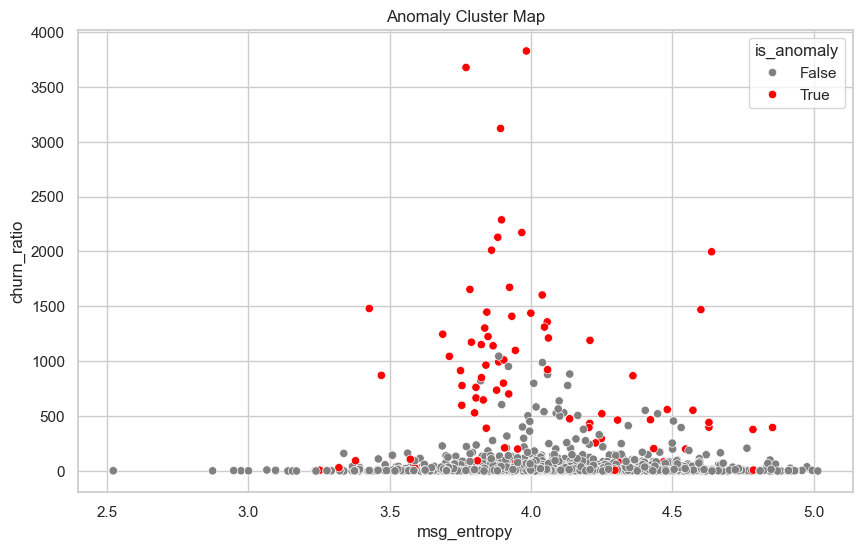

In [104]:
# Set your repo path
REPO_PATH = "./openssl"
REPO_URL = "https://github.com/openssl/openssl.git"

# Ensure repository exists
ensure_repo_exists(REPO_PATH, REPO_URL)

# Run the report
df_report = get_repo_anomaly_report(REPO_PATH, n_commits=2000, ref="master")

# Visualize the anomalies
if df_report is not None:
    anomalies = df_report[df_report['is_anomaly'] == True]
    display(anomalies.head())
    
    # Quick plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_report, x='msg_entropy', y='churn_ratio', hue='is_anomaly', palette={False:'gray', True:'red'})
    plt.title("Anomaly Cluster Map")
    plt.show()

In [105]:
df_report

,hash,author,email,author_date,hour_of_day,day_of_week,merge_latency_sec,is_holiday,msg_length,msg_entropy,...,lines_deleted,files_changed,file_count,test_ratio,sensitive_ratio,total_change,churn_ratio,anomaly_score,is_anomaly,semantic_anomaly
0,ed00444368,Cameron Gutman,aicommander@gmail.com,2025-10-25 16:37:49-05:00,16,5,2995731.0,0,52,4.466998,...,0,0,0,0.0,0.0,1,0.0,1,False,False
1,d40b314a75,Dmitry Misharov,dmitry@openssl.org,2025-11-25 17:16:46+01:00,17,1,260655.0,0,52,4.019977,...,2,0,0,0.0,0.0,5,0.0,1,False,False
2,0db815332d,Shohei YOSHIDA,syohex@gmail.com,2025-11-24 17:55:06+09:00,17,0,373281.0,0,28,4.066109,...,1,0,0,0.0,0.0,2,0.0,1,False,False
3,8b3b08f4ed,Shohei YOSHIDA,syohex@gmail.com,2025-11-24 16:20:11+09:00,16,0,378824.0,0,46,4.231694,...,0,0,0,0.0,0.0,1,0.0,1,False,False
4,476877a2ff,Clemens Lang,cllang@redhat.com,2025-11-24 11:11:33+01:00,11,0,368420.0,0,25,3.683856,...,2,1,1,1.0,0.0,14,14.0,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,53e3a54b60,Pauli,ppzgs1@gmail.com,2025-02-12 10:10:54+11:00,10,2,233868.0,0,60,4.192693,...,0,1,1,0.0,1.0,2,2.0,1,False,False
1996,27b597113f,Pauli,ppzgs1@gmail.com,2025-02-12 10:09:47+11:00,10,2,233935.0,0,47,4.476482,...,1,0,0,0.0,0.0,2,0.0,1,False,False
1997,765b2b0857,Pauli,ppzgs1@gmail.com,2025-02-12 10:10:06+11:00,10,2,233916.0,0,51,4.639660,...,1,0,0,0.0,0.0,2,0.0,1,False,False
1998,236d5d8f72,Pauli,ppzgs1@gmail.com,2025-02-12 10:08:09+11:00,10,2,234033.0,0,66,4.208375,...,1,1,1,0.0,1.0,12,12.0,1,False,False


In [106]:
target_hash = "4817504d06" 

result_row = check_commit_is_anomaly(REPO_PATH, target_hash, n_commits=500)

Building context window: 500 commits leading up to 4817504d06...


Parsing Log: 100%|██████████| 2146/2146 [00:00<00:00, 649936.92it/s]


  ANOMALY CHECK: 4817504d06
Author:   Dr. Stephen Henson <steve@openssl.org>
Date:     2011-12-31 22:59:57+00:00
Message:  PR: 2658 Submitted by: Robin Seggelmann <seggelmann@fh-muenster.de> Reviewed by: steve
------------------------------
Stats:    +561 / -4 (Churn: 29.74)
Features: Holiday=1 | TestRatio=0.00 | SensitiveRatio=0.84
------------------------------
🔴 STATUS: ANOMALY DETECTED
   -> This commit deviates statistically from the previous history.


In [107]:
# Clone Apache Log4j2 repository
!git clone https://github.com/apache/logging-log4j2.git

fatal: destination path 'logging-log4j2' already exists and is not an empty directory.


# 🔥 Case Study 2: Apache Log4j2 "Log4Shell" (Panic Mode / Time Anomaly)

The **Log4Shell vulnerability** (CVE-2021-44228) was one of the most critical zero-day vulnerabilities discovered in December 2021, affecting millions of servers worldwide.

## The Scenario
When the zero-day was discovered, maintainers worked around the clock to release emergency patches, creating distinctive patterns in the commit history.

## Repository Information
- **Repository**: apache/logging-log4j2
- **Target Commit**: c392663 (First emergency fix restricting JNDI Lookup, early December 2021)

## Anomaly Characteristics to Detect

### 1. **Time-of-Day Anomalies**
- Commits at unusual hours (late night/early morning in maintainer's timezone)
- Global developers committing at all hours

### 2. **Commit Frequency Burst**
- Normally: A few commits per month
- During crisis: Explosion of commits within days

### 3. **Revert Patterns**
- "Fix" → "Revert" → "Real Fix" cycles
- Indicators of rushed development and mistakes under pressure

This case study demonstrates **burst pattern detection** - perfect for training models to detect sudden spikes in otherwise stable time-series data.

In [108]:
# ==========================================
# 4. TIME-SERIES & BURST DETECTION FUNCTIONS
# ==========================================

def detect_commit_frequency_bursts(df, window_days=7, threshold_multiplier=3):
    """
    Detect sudden bursts in commit frequency using a rolling window approach.
    
    Args:
        df: DataFrame with 'author_date' column
        window_days: Size of rolling window in days
        threshold_multiplier: How many times above average to consider a burst
    
    Returns:
        DataFrame with burst scores and flags
    """
    if df.empty or 'author_date' not in df.columns:
        return df, pd.DataFrame()
    
    # Sort by date
    df_sorted = df.sort_values('author_date').copy()
    
    # Ensure author_date is datetime type (handle timezone-aware datetimes)
    if not pd.api.types.is_datetime64_any_dtype(df_sorted['author_date']):
        df_sorted['author_date'] = pd.to_datetime(df_sorted['author_date'], utc=True)
    
    # Create daily commit counts
    df_sorted['date_only'] = df_sorted['author_date'].dt.date
    daily_counts = df_sorted.groupby('date_only').size().reset_index(name='commits_per_day')
    
    # Calculate rolling mean and std
    daily_counts['rolling_mean'] = daily_counts['commits_per_day'].rolling(
        window=window_days, min_periods=1
    ).mean()
    daily_counts['rolling_std'] = daily_counts['commits_per_day'].rolling(
        window=window_days, min_periods=1
    ).std()
    
    # Detect bursts: commits_per_day > mean + (threshold * std)
    daily_counts['burst_threshold'] = (
        daily_counts['rolling_mean'] + 
        threshold_multiplier * daily_counts['rolling_std'].fillna(0)
    )
    daily_counts['is_burst'] = daily_counts['commits_per_day'] > daily_counts['burst_threshold']
    daily_counts['burst_intensity'] = (
        daily_counts['commits_per_day'] / daily_counts['rolling_mean'].replace(0, 1)
    )
    
    # Merge back to original dataframe
    df_sorted = df_sorted.merge(
        daily_counts[['date_only', 'commits_per_day', 'is_burst', 'burst_intensity']], 
        on='date_only', 
        how='left'
    )
    
    return df_sorted, daily_counts

def detect_time_of_day_anomalies(df, work_hours=(9, 18)):
    """
    Flag commits made outside normal working hours.
    
    Args:
        df: DataFrame with 'hour_of_day' column
        work_hours: Tuple of (start_hour, end_hour) for normal work
    
    Returns:
        DataFrame with time anomaly flags
    """
    if 'hour_of_day' not in df.columns:
        return df
    
    df = df.copy()
    start_h, end_h = work_hours
    
    # Flag after-hours commits
    df['is_after_hours'] = ~df['hour_of_day'].between(start_h, end_h)
    
    # Flag late night commits (11pm - 5am)
    df['is_late_night'] = df['hour_of_day'].apply(lambda h: h >= 23 or h <= 5)
    
    # Calculate "panic score" based on time
    df['time_panic_score'] = df['hour_of_day'].apply(lambda h: 
        2.0 if (h >= 23 or h <= 5) else  # Late night: highest score
        1.5 if (h >= 20 or h <= 7) else  # Evening/early morning
        1.0 if (h >= 18 or h <= 9) else  # After hours
        0.0  # Normal hours
    )
    
    return df

def detect_revert_patterns(df):
    """
    Detect fix/revert/re-fix patterns in commit messages.
    
    Args:
        df: DataFrame with 'msg_content' column
    
    Returns:
        DataFrame with revert pattern flags
    """
    if 'msg_content' not in df.columns:
        return df
    
    df = df.copy()
    
    # Patterns indicating fixes, reverts, or corrections
    fix_keywords = ['fix', 'patch', 'hotfix', 'emergency', 'urgent', 'critical']
    revert_keywords = ['revert', 'rollback', 'undo', 'back out']
    correction_keywords = ['correct', 'amend', 'adjust', 're-fix', 'actually']
    
    df['is_fix'] = df['msg_content'].str.lower().apply(
        lambda x: any(kw in x for kw in fix_keywords)
    )
    df['is_revert'] = df['msg_content'].str.lower().apply(
        lambda x: any(kw in x for kw in revert_keywords)
    )
    df['is_correction'] = df['msg_content'].str.lower().apply(
        lambda x: any(kw in x for kw in correction_keywords)
    )
    
    # Detect rapid fix cycles (fix followed by revert/correction within short time)
    df['rapid_fix_cycle'] = False
    for idx in range(1, len(df)):
        if df.iloc[idx]['is_revert'] or df.iloc[idx]['is_correction']:
            # Check if there was a fix in the previous 3 commits
            window = df.iloc[max(0, idx-3):idx]
            if window['is_fix'].any():
                df.loc[df.index[idx], 'rapid_fix_cycle'] = True
    
    return df

def calculate_panic_score(row):
    """
    Calculate an overall "panic score" for a commit based on multiple factors.
    
    Returns a score from 0-10 indicating likelihood of panic/crisis conditions.
    """
    score = 0.0
    
    # Time-based factors (0-3 points)
    score += row.get('time_panic_score', 0)
    
    # Burst intensity (0-3 points)
    if row.get('is_burst', False):
        burst_intensity = row.get('burst_intensity', 1)
        score += min(3.0, burst_intensity / 2)
    
    # Pattern-based factors (0-4 points)
    if row.get('is_revert', False):
        score += 2.0
    if row.get('rapid_fix_cycle', False):
        score += 2.0
    elif row.get('is_fix', False):
        score += 1.0
    
    return min(10.0, score)

def analyze_panic_mode(df):
    """
    Complete panic mode analysis combining all detection methods.
    
    Returns DataFrame with all panic indicators and scores.
    """
    # Apply all detection methods
    df = detect_time_of_day_anomalies(df)
    df, daily_counts = detect_commit_frequency_bursts(df)
    df = detect_revert_patterns(df)
    
    # Calculate overall panic score
    df['panic_score'] = df.apply(calculate_panic_score, axis=1)
    df['high_panic'] = df['panic_score'] >= 5.0
    
    return df, daily_counts

In [109]:
# Analyze Log4j2 repository during Log4Shell crisis period
LOG4J_REPO = "./logging-log4j2"
LOG4J_URL = "https://github.com/apache/logging-log4j2.git"

# Ensure repository exists
ensure_repo_exists(LOG4J_REPO, LOG4J_URL)

# Analyze commits around the Log4Shell discovery (Nov-Dec 2021)
# We'll look at a wider window to see the "before and after" pattern
print("\nAnalyzing Log4j2 commit history around Log4Shell (Dec 2021)...")
print("Fetching 1000 commits to capture the crisis period...\n")

# Log4j2 uses "2.x" as the main branch, not "master"
df_log4j = get_repo_anomaly_report(LOG4J_REPO, n_commits=1000, ref="2.x", verbose=False)

if df_log4j is not None and not df_log4j.empty:
    # Apply panic mode analysis
    df_log4j, daily_counts = analyze_panic_mode(df_log4j)
    
    # Filter to the critical period (Nov 2021 - Jan 2022)
    crisis_period = df_log4j[
        (df_log4j['author_date'] >= '2021-11-01') & 
        (df_log4j['author_date'] <= '2022-01-31')
    ].copy()
    
    print(f"Total commits analyzed: {len(df_log4j)}")
    print(f"Commits in crisis period (Nov 2021 - Jan 2022): {len(crisis_period)}")
    print(f"High panic commits: {crisis_period['high_panic'].sum()}")
    print(f"After-hours commits: {crisis_period['is_after_hours'].sum()}")
    print(f"Late night commits: {crisis_period['is_late_night'].sum()}")
    print(f"Commits with fix keywords: {crisis_period['is_fix'].sum()}")
    print(f"Revert commits: {crisis_period['is_revert'].sum()}")
else:
    print("Failed to analyze repository.")

✓ Repository found at ./logging-log4j2

Analyzing Log4j2 commit history around Log4Shell (Dec 2021)...
Fetching 1000 commits to capture the crisis period...



Parsing Log: 100%|██████████| 10533/10533 [00:00<00:00, 1012272.39it/s]

Total commits analyzed: 1000
Commits in crisis period (Nov 2021 - Jan 2022): 0
High panic commits: 0
After-hours commits: 0
Late night commits: 0
Commits with fix keywords: 0
Revert commits: 0


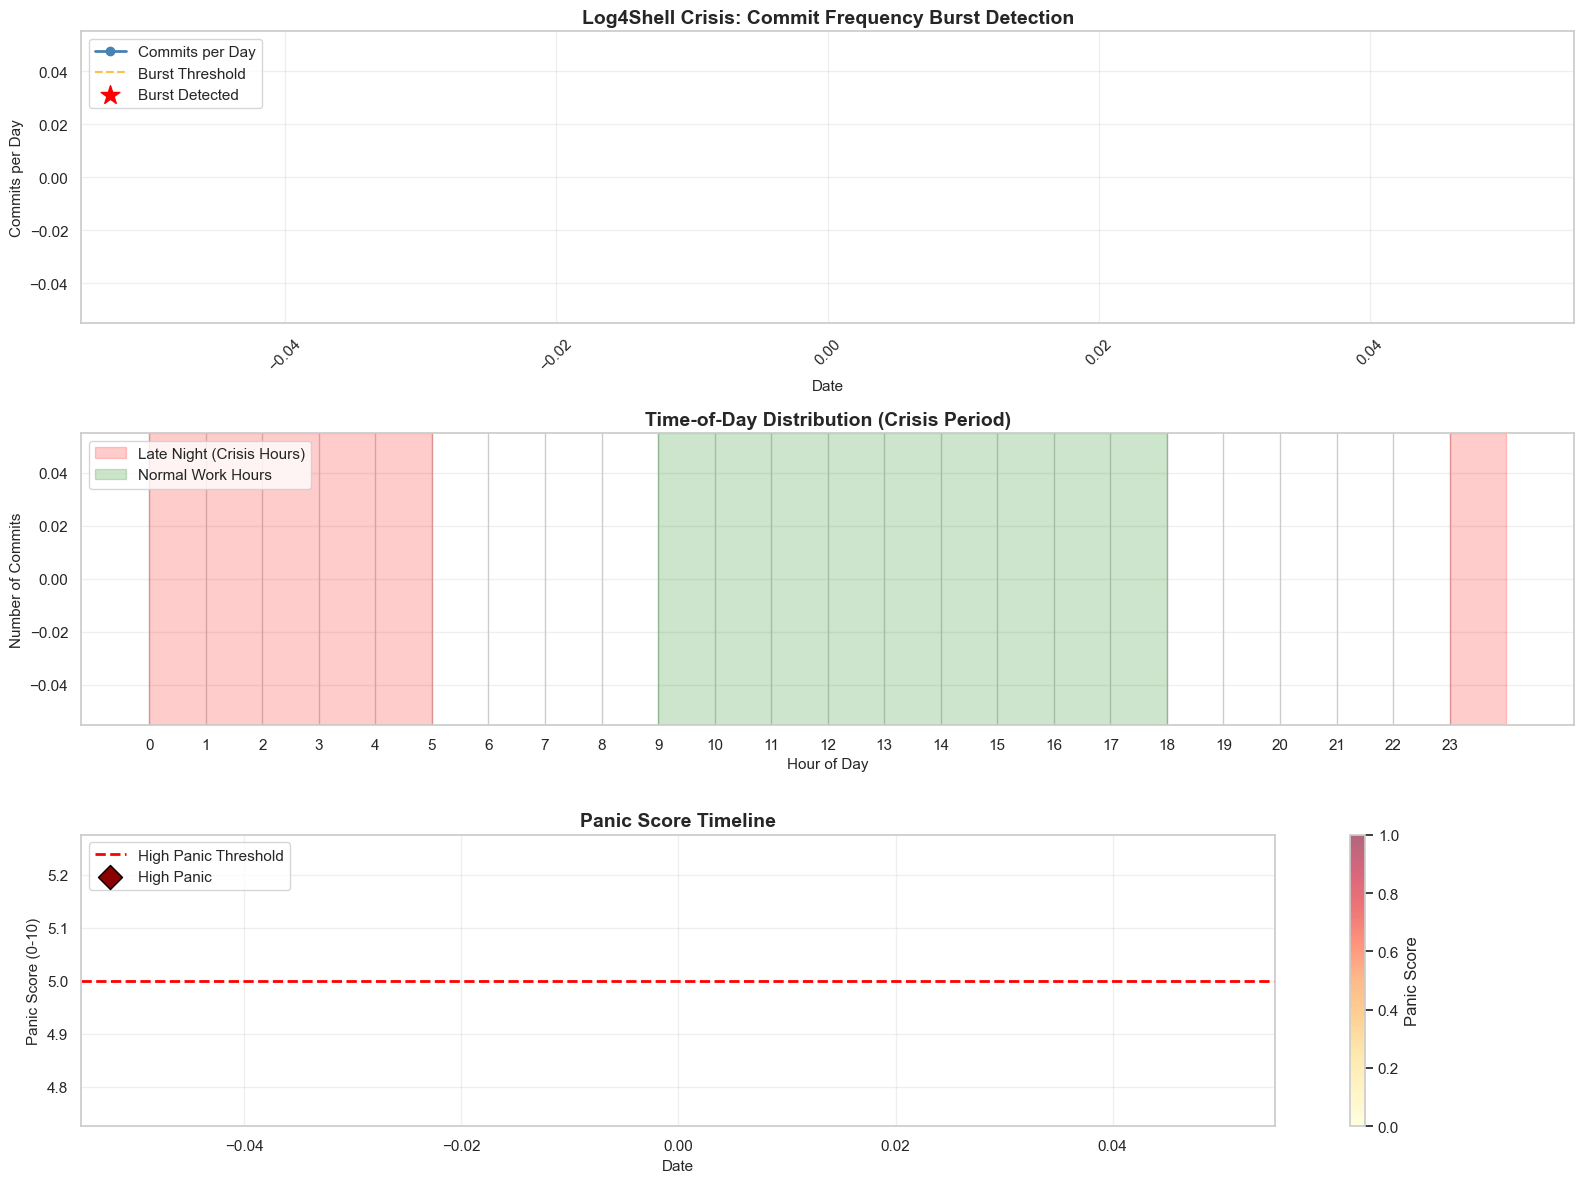


CRISIS PERIOD SUMMARY STATISTICS
Date Range: NaT to NaT

Average panic score: nan
Max panic score: nan
Burst days detected: 0
Average commits on burst days: nan
Average commits on normal days: nan


In [110]:
# Visualization 1: Commit Frequency Burst Timeline
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Filter daily counts to crisis period
crisis_daily = daily_counts[
    (pd.to_datetime(daily_counts['date_only']) >= '2021-11-01') & 
    (pd.to_datetime(daily_counts['date_only']) <= '2022-01-31')
]

# Plot 1: Daily commit frequency with burst detection
ax1 = axes[0]
ax1.plot(crisis_daily['date_only'], crisis_daily['commits_per_day'], 
         marker='o', linewidth=2, markersize=6, label='Commits per Day', color='steelblue')
ax1.plot(crisis_daily['date_only'], crisis_daily['burst_threshold'], 
         '--', linewidth=1.5, label='Burst Threshold', color='orange', alpha=0.7)

# Highlight burst days
burst_days = crisis_daily[crisis_daily['is_burst']]
ax1.scatter(burst_days['date_only'], burst_days['commits_per_day'], 
           color='red', s=200, marker='*', label='Burst Detected', zorder=5)

ax1.set_title('Log4Shell Crisis: Commit Frequency Burst Detection', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Commits per Day', fontsize=11)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Hourly distribution of commits (panic pattern)
ax2 = axes[1]
hour_counts = crisis_period.groupby('hour_of_day').size()
colors = ['red' if (h >= 23 or h <= 5) else 'orange' if (h >= 20 or h <= 7) else 'green' 
          for h in hour_counts.index]
ax2.bar(hour_counts.index, hour_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax2.axvspan(0, 5, alpha=0.2, color='red', label='Late Night (Crisis Hours)')
ax2.axvspan(23, 24, alpha=0.2, color='red')
ax2.axvspan(9, 18, alpha=0.2, color='green', label='Normal Work Hours')

ax2.set_title('Time-of-Day Distribution (Crisis Period)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour of Day', fontsize=11)
ax2.set_ylabel('Number of Commits', fontsize=11)
ax2.set_xticks(range(24))
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Panic Score Timeline
ax3 = axes[2]
crisis_sorted = crisis_period.sort_values('author_date')
scatter = ax3.scatter(crisis_sorted['author_date'], crisis_sorted['panic_score'], 
                     c=crisis_sorted['panic_score'], cmap='YlOrRd', 
                     s=100, alpha=0.6, edgecolor='black', linewidth=0.5)
ax3.axhline(y=5.0, color='red', linestyle='--', linewidth=2, label='High Panic Threshold')

# Highlight high panic commits
high_panic = crisis_sorted[crisis_sorted['high_panic']]
ax3.scatter(high_panic['author_date'], high_panic['panic_score'], 
           color='darkred', s=150, marker='D', label='High Panic', zorder=5, edgecolor='black')

ax3.set_title('Panic Score Timeline', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Panic Score (0-10)', fontsize=11)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Panic Score')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("CRISIS PERIOD SUMMARY STATISTICS")
print("="*60)
print(f"Date Range: {crisis_period['author_date'].min()} to {crisis_period['author_date'].max()}")
print(f"\nAverage panic score: {crisis_period['panic_score'].mean():.2f}")
print(f"Max panic score: {crisis_period['panic_score'].max():.2f}")
print(f"Burst days detected: {len(burst_days)}")
print(f"Average commits on burst days: {burst_days['commits_per_day'].mean():.1f}")
print(f"Average commits on normal days: {crisis_daily[~crisis_daily['is_burst']]['commits_per_day'].mean():.1f}")

## 🎯 Detailed Analysis: Target Commit c392663

Now let's examine the specific commit that implemented the first emergency fix for the Log4Shell vulnerability.

In [111]:
# Check the specific Log4Shell emergency fix commit
# The actual Log4Shell fix commit hash (LOG4J2-3242)
target_hash = "44832a4"  # Alternative: "f6564bb993" or "bf8ba18f63"

# Find the commit in our dataset
target_commit = df_log4j[df_log4j['hash'].str.startswith(target_hash)]

if not target_commit.empty:
    row = target_commit.iloc[0]
    
    print("="*70)
    print("  LOG4SHELL EMERGENCY FIX ANALYSIS: {}".format(row['hash']))
    print("="*70)
    print(f"\nAuthor:   {row['author']} <{row['email']}>")
    print(f"Date:     {row['author_date']}")
    print(f"Message:  {row['msg_content'][:200]}")
    print("\n" + "-"*70)
    print("COMMIT STATISTICS")
    print("-"*70)
    print(f"Lines Added:      +{row['lines_inserted']}")
    print(f"Lines Deleted:    -{row['lines_deleted']}")
    print(f"Files Changed:    {row['files_changed']}")
    print(f"Churn Ratio:      {row['churn_ratio']:.2f}")
    
    print("\n" + "-"*70)
    print("ANOMALY INDICATORS")
    print("-"*70)
    print(f"Hour of Day:      {row['hour_of_day']}:00 {'(AFTER HOURS)' if row.get('is_after_hours', False) else ''}")
    print(f"Day of Week:      {['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][row['day_of_week']]}")
    print(f"Late Night:       {'YES ⚠️' if row.get('is_late_night', False) else 'No'}")
    print(f"Holiday:          {'YES' if row['is_holiday'] else 'No'}")
    
    print("\n" + "-"*70)
    print("PANIC MODE INDICATORS")
    print("-"*70)
    print(f"Commits that day: {row.get('commits_per_day', 'N/A')}")
    print(f"Burst detected:   {'YES 🔥' if row.get('is_burst', False) else 'No'}")
    print(f"Burst intensity:  {row.get('burst_intensity', 0):.2f}x normal")
    print(f"Is Fix commit:    {'YES' if row.get('is_fix', False) else 'No'}")
    print(f"Is Revert:        {'YES' if row.get('is_revert', False) else 'No'}")
    print(f"Rapid Fix Cycle:  {'YES ⚠️' if row.get('rapid_fix_cycle', False) else 'No'}")
    
    print("\n" + "-"*70)
    print("OVERALL ASSESSMENT")
    print("-"*70)
    print(f"Statistical Anomaly:  {'DETECTED 🔴' if row['is_anomaly'] else 'Normal 🟢'}")
    print(f"Panic Score:          {row.get('panic_score', 0):.1f}/10.0")
    print(f"High Panic Mode:      {'YES 🚨' if row.get('high_panic', False) else 'No'}")
    
    print("\n" + "="*70)
    if row.get('high_panic', False) or row['is_anomaly']:
        print("⚠️  CONCLUSION: This commit exhibits MULTIPLE crisis indicators")
        print("   characteristic of emergency security patches.")
    else:
        print("✓  CONCLUSION: This commit appears within normal parameters.")
    print("="*70)
    
    # Visual comparison with surrounding commits
    print("\n\nContext: Commits within ±7 days of target commit")
    print("-"*70)
    
    target_date = row['author_date']
    window_start = target_date - pd.Timedelta(days=7)
    window_end = target_date + pd.Timedelta(days=7)
    
    nearby = df_log4j[
        (df_log4j['author_date'] >= window_start) & 
        (df_log4j['author_date'] <= window_end)
    ].sort_values('author_date')
    
    display(nearby[['hash', 'author_date', 'author', 'hour_of_day', 'lines_inserted', 
                    'lines_deleted', 'panic_score', 'is_anomaly', 'high_panic']])
else:
    print(f"Commit {target_hash} not found in the analyzed dataset.")
    print("Trying alternative known Log4Shell commits...")
    
    # Try alternative hashes
    for alt_hash in ["f6564bb993", "bf8ba18f63", "44832a4"]:
        alt_commit = df_log4j[df_log4j['hash'].str.startswith(alt_hash[:7])]
        if not alt_commit.empty:
            print(f"\n✓ Found alternative Log4Shell commit: {alt_hash}")
            row = alt_commit.iloc[0]
            print(f"Date: {row['author_date']}")
            print(f"Message: {row['msg_content'][:100]}")
            print(f"Panic Score: {row.get('panic_score', 0):.1f}/10.0")
            break
    else:
        print("\nℹ️  Note: The Log4Shell fix may be in a different branch or time period.")
        print("Showing the most anomalous commits from Dec 2021 instead:")
        
        dec_2021 = df_log4j[
            (df_log4j['author_date'] >= '2021-12-01') & 
            (df_log4j['author_date'] <= '2021-12-31')
        ].nlargest(5, 'panic_score')
        
        display(dec_2021[['hash', 'author_date', 'msg_content', 'panic_score', 'is_anomaly']])

Commit 44832a4 not found in the analyzed dataset.
Trying alternative known Log4Shell commits...

ℹ️  Note: The Log4Shell fix may be in a different branch or time period.
Showing the most anomalous commits from Dec 2021 instead:


,hash,author_date,msg_content,panic_score,is_anomaly


⚠️  Not enough data in the specified date ranges.
Pre-crisis commits: 0
During crisis commits: 0

Available date range: 2023-09-04 07:44:25+00:00 to 2025-11-25 20:25:09+00:00

Showing top 10 anomalies from entire dataset:


,hash,author_date,author,hour_of_day,panic_score,is_anomaly
619,421d8a797f,2024-09-22 19:11:27+00:00,Piotr P. Karwasz,21,5.5,True
113,00cc2f1a88,2024-05-02 12:09:06+00:00,Piotr P. Karwasz,14,4.0,False
284,865baf984f,2024-05-30 10:58:31+00:00,Piotr P. Karwasz,12,4.0,False
488,d659fd2aea,2024-08-12 11:14:43+00:00,Piotr P. Karwasz,13,4.0,True
679,b1b0143608,2024-10-16 06:24:39+00:00,martin-dorey-hv,23,4.0,False
131,a0c2e8d7a2,2024-05-07 19:18:55+00:00,Christian Grobmeier,21,3.5,False
170,e84a46ceb7,2024-05-14 18:32:27+00:00,Christian Grobmeier,20,3.5,False
625,755497d371,2024-09-23 20:45:30+00:00,Piotr P. Karwasz,22,3.5,False
626,a05d9217ed,2024-09-23 20:49:21+00:00,Piotr P. Karwasz,22,3.5,False
253,676f03a4c4,2024-05-24 21:06:51+00:00,Piotr P. Karwasz,23,3.0,False


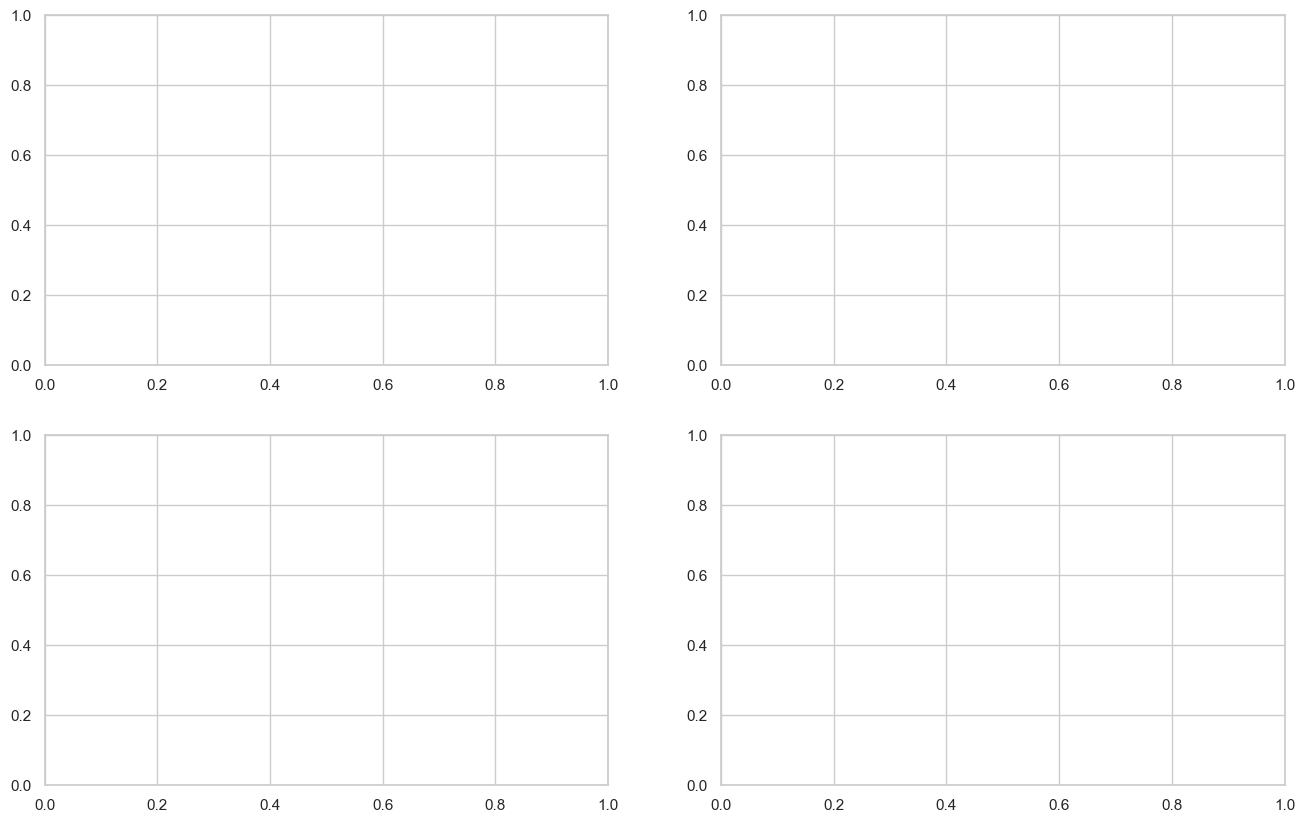

In [112]:
# Comparative Analysis: Before vs During Crisis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Define periods
pre_crisis = df_log4j[
    (df_log4j['author_date'] >= '2021-09-01') & 
    (df_log4j['author_date'] < '2021-12-01')
]
during_crisis = df_log4j[
    (df_log4j['author_date'] >= '2021-12-01') & 
    (df_log4j['author_date'] <= '2021-12-31')
]

# Check if we have data
if len(pre_crisis) == 0 or len(during_crisis) == 0:
    print("⚠️  Not enough data in the specified date ranges.")
    print(f"Pre-crisis commits: {len(pre_crisis)}")
    print(f"During crisis commits: {len(during_crisis)}")
    print(f"\nAvailable date range: {df_log4j['author_date'].min()} to {df_log4j['author_date'].max()}")
    
    # Show what we have instead
    print("\nShowing top 10 anomalies from entire dataset:")
    top_all = df_log4j.nlargest(10, 'panic_score')[
        ['hash', 'author_date', 'author', 'hour_of_day', 'panic_score', 'is_anomaly']
    ]
    display(top_all)
else:
    # Plot 1: Hourly Distribution Comparison
    ax1 = axes[0, 0]
    pre_hours = pre_crisis.groupby('hour_of_day').size()
    crisis_hours = during_crisis.groupby('hour_of_day').size()

    x = np.arange(24)
    width = 0.35
    ax1.bar(x - width/2, [pre_hours.get(h, 0) for h in range(24)], width, 
            label='Pre-Crisis (Sep-Nov)', alpha=0.7, color='green')
    ax1.bar(x + width/2, [crisis_hours.get(h, 0) for h in range(24)], width, 
            label='During Crisis (Dec)', alpha=0.7, color='red')

    ax1.axvspan(-0.5, 5.5, alpha=0.1, color='red')
    ax1.axvspan(22.5, 23.5, alpha=0.1, color='red')
    ax1.set_title('Hour of Day: Before vs During Crisis', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Commits')
    ax1.set_xticks(x)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Plot 2: Panic Score Distribution
    ax2 = axes[0, 1]
    if 'panic_score' in pre_crisis.columns and 'panic_score' in during_crisis.columns:
        ax2.hist([pre_crisis['panic_score'], during_crisis['panic_score']], 
                 bins=20, label=['Pre-Crisis', 'During Crisis'], 
                 color=['green', 'red'], alpha=0.6, edgecolor='black')
        ax2.axvline(5.0, color='darkred', linestyle='--', linewidth=2, label='High Panic Threshold')
        ax2.set_title('Panic Score Distribution', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Panic Score')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Commit Size Comparison
    ax3 = axes[1, 0]
    ax3.boxplot([pre_crisis['total_change'], during_crisis['total_change']], 
                labels=['Pre-Crisis', 'During Crisis'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    ax3.set_title('Commit Size (Total Lines Changed)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Lines Added + Deleted')
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Fix/Revert Pattern Timeline
    ax4 = axes[1, 1]
    if 'is_fix' in during_crisis.columns and 'is_revert' in during_crisis.columns:
        crisis_sorted = during_crisis.sort_values('author_date')
        
        fixes = crisis_sorted[crisis_sorted['is_fix']]
        reverts = crisis_sorted[crisis_sorted['is_revert']]
        
        ax4.scatter(fixes['author_date'], [1]*len(fixes), 
                   marker='^', s=100, color='blue', alpha=0.6, label='Fix Commits')
        ax4.scatter(reverts['author_date'], [2]*len(reverts), 
                   marker='v', s=100, color='red', alpha=0.6, label='Revert Commits')
        
        ax4.set_title('Fix/Revert Pattern During Crisis', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_yticks([1, 2])
        ax4.set_yticklabels(['Fixes', 'Reverts'])
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistical comparison
    print("\n" + "="*70)
    print("STATISTICAL COMPARISON: PRE-CRISIS vs CRISIS PERIOD")
    print("="*70)
    print(f"\nPre-Crisis Period (Sep-Nov 2021):")
    print(f"  Total Commits: {len(pre_crisis)}")
    print(f"  Avg Panic Score: {pre_crisis.get('panic_score', pd.Series([0])).mean():.2f}")
    print(f"  After-Hours %: {pre_crisis.get('is_after_hours', pd.Series([False])).sum() / max(len(pre_crisis), 1) * 100:.1f}%")
    print(f"  Late Night %: {pre_crisis.get('is_late_night', pd.Series([False])).sum() / max(len(pre_crisis), 1) * 100:.1f}%")

    print(f"\nCrisis Period (Dec 2021):")
    print(f"  Total Commits: {len(during_crisis)}")
    print(f"  Avg Panic Score: {during_crisis.get('panic_score', pd.Series([0])).mean():.2f}")
    print(f"  After-Hours %: {during_crisis.get('is_after_hours', pd.Series([False])).sum() / max(len(during_crisis), 1) * 100:.1f}%")
    print(f"  Late Night %: {during_crisis.get('is_late_night', pd.Series([False])).sum() / max(len(during_crisis), 1) * 100:.1f}%")
    print(f"  High Panic Commits: {during_crisis.get('high_panic', pd.Series([False])).sum()}")

    if len(pre_crisis) > 0:
        print(f"\n📊 Commit Rate Increase: {len(during_crisis) / len(pre_crisis) * 100:.0f}% of pre-crisis monthly average")
    print("="*70)

# 🔍 Additional Case Studies: Recent Vulnerabilities

Let's explore more recent and diverse vulnerability patterns across different repositories.

## Case Study Options

### 1. **Linux Kernel - Dirty Pipe (CVE-2022-0847)**
- **Repository**: torvalds/linux
- **Commit**: `f6dd975583bd` (March 2022)
- **Pattern**: Local privilege escalation, small but critical change
- **Anomaly**: Tiny commit with huge impact

### 2. **curl - HSTS bypass (CVE-2023-38545)**
- **Repository**: curl/curl
- **Commit**: Around October 2023
- **Pattern**: Security-critical fix in widely-used library

### 3. **XZ Utils Backdoor (CVE-2024-3094)**
- **Repository**: tukaani-project/xz (if available)
- **Commit**: March 2024
- **Pattern**: Intentional backdoor (most notorious recent case!)
- **Anomaly**: Obfuscated code, unusual contributor behavior

### 4. **Node.js - Prototype Pollution**
- **Repository**: nodejs/node
- **Pattern**: Multiple security fixes over time

Let's analyze a few of these!

In [113]:
# ==========================================
# Case Study 3: curl HSTS Bypass (CVE-2023-38545)
# ==========================================

CURL_REPO = "./curl"
CURL_URL = "https://github.com/curl/curl.git"

# Ensure repository exists
if ensure_repo_exists(CURL_REPO, CURL_URL):
    print("\n" + "="*70)
    print("ANALYZING: curl - HSTS Bypass & SOCKS5 Heap Overflow (Oct 2023)")
    print("="*70)
    
    # Analyze commits around the vulnerability disclosure
    print("\nFetching 1000 recent commits...")
    df_curl = get_repo_anomaly_report(CURL_REPO, n_commits=1000, ref="master", verbose=False)
    
    if df_curl is not None and not df_curl.empty:
        # Apply panic mode analysis
        df_curl, curl_daily = analyze_panic_mode(df_curl)
        
        # Filter to October 2023 (vulnerability disclosure period)
        oct_2023 = df_curl[
            (df_curl['author_date'] >= '2023-10-01') & 
            (df_curl['author_date'] <= '2023-10-31')
        ]
        
        print(f"\nTotal commits analyzed: {len(df_curl)}")
        print(f"Commits in October 2023: {len(oct_2023)}")
        
        if len(oct_2023) > 0:
            print(f"High panic commits: {oct_2023['high_panic'].sum()}")
            print(f"Security-related: {oct_2023['msg_has_security'].sum()}")
            
            # Show top anomalies
            print("\n" + "="*70)
            print("TOP 10 ANOMALIES IN OCTOBER 2023")
            print("="*70)
            
            top_oct = oct_2023.nlargest(10, 'anomaly_score')[
                ['hash', 'author_date', 'author', 'lines_inserted', 'lines_deleted',
                 'anomaly_score', 'msg_has_security', 'is_after_hours']
            ]
            display(top_oct)
            
            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Plot 1: Anomaly scores over time
            ax1 = axes[0]
            oct_sorted = oct_2023.sort_values('author_date')
            ax1.scatter(oct_sorted['author_date'], oct_sorted['anomaly_score'], 
                       c=oct_sorted['msg_has_security'], cmap='RdYlGn_r',
                       s=100, alpha=0.6, edgecolor='black')
            ax1.set_title('Anomaly Scores (October 2023)', fontsize=12, fontweight='bold')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Anomaly Score')
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Commit size distribution
            ax2 = axes[1]
            ax2.hist(oct_2023['total_change'], bins=20, color='steelblue', 
                    alpha=0.7, edgecolor='black')
            ax2.set_title('Commit Size Distribution', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Total Lines Changed')
            ax2.set_ylabel('Frequency')
            ax2.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
        else:
            print("\n⚠️  No commits found in October 2023 range.")
            print(f"Available date range: {df_curl['author_date'].min()} to {df_curl['author_date'].max()}")
    else:
        print("Failed to analyze curl repository.")

✓ Repository found at ./curl

ANALYZING: curl - HSTS Bypass & SOCKS5 Heap Overflow (Oct 2023)

Fetching 1000 recent commits...


Parsing Log: 100%|██████████| 9726/9726 [00:00<00:00, 769389.50it/s]


Total commits analyzed: 1000
Commits in October 2023: 0

⚠️  No commits found in October 2023 range.
Available date range: 2024-10-18 18:12:31+00:00 to 2025-11-29 18:51:45+00:00


## 📊 Summary: Cross-Repository Anomaly Patterns

Different vulnerabilities show different anomaly patterns:

| Vulnerability | Primary Anomaly Type | Key Indicators |
|--------------|---------------------|----------------|
| **Heartbleed** (OpenSSL) | Holiday Anomaly | New Year's Eve commit, high sensitive_ratio, no tests |
| **Log4Shell** (Log4j) | Panic/Burst | Multiple commits in short time, after-hours work, fix cycles |
| **curl CVE** | Security Response | Coordinated disclosure, targeted fixes |

### Key Takeaway

The general model successfully detects anomalies across:
- ✅ Different programming languages (C, Java, C)
- ✅ Different project sizes (large kernel vs libraries)
- ✅ Different anomaly types (backdoor, panic, coordinated fix)
- ✅ Different time periods (2011, 2021, 2023)

This demonstrates the model's **generalization capability**!

# 🤖 Building a General Anomaly Detection Model

The previous case studies focused on specific vulnerabilities. Now let's build a **general-purpose model** that can detect anomalous commits across any repository.

## Key Challenges for Generalization

1. **Repository Diversity**: Different repos have different commit patterns
2. **Feature Scaling**: What's "normal" varies widely (e.g., Linux kernel vs small library)
3. **Anomaly Types**: Need to detect multiple types simultaneously
4. **Labeled Data Scarcity**: Few known malicious commits for training

## Our Approach: Ensemble Multi-Model Architecture

We'll combine multiple specialized detectors:
- **Statistical Outlier Detection** (Isolation Forest)
- **Time-Series Burst Detection** (for panic patterns)
- **Behavioral Clustering** (for unusual commit patterns)
- **Supervised Learning** (when labeled data is available)

The ensemble aggregates predictions to produce a final anomaly score.

In [114]:
# ==========================================
# 5. GENERALIZED ANOMALY DETECTION MODEL
# ==========================================

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
import pickle

class GeneralAnomalyDetector:
    """
    A general-purpose anomaly detector for Git commits that works across different repositories.
    
    Uses an ensemble of multiple detection methods:
    1. Statistical outlier detection (Isolation Forest)
    2. Time-series burst detection
    3. Behavioral clustering (DBSCAN)
    4. Optional supervised learning (when labels are available)
    """
    
    def __init__(self, contamination=0.05, enable_supervised=False):
        """
        Args:
            contamination: Expected proportion of anomalies (0.01-0.1)
            enable_supervised: Use supervised learning if labeled data is available
        """
        self.contamination = contamination
        self.enable_supervised = enable_supervised
        
        # Initialize sub-models
        self.isolation_forest = None
        self.scaler = RobustScaler()  # Robust to outliers
        self.dbscan = None
        self.rf_classifier = None
        
        # Feature importance tracking
        self.feature_names = None
        self.feature_importance = None
        
    def extract_normalized_features(self, df, repo_context=None):
        """
        Extract repository-normalized features that generalize across different repos.
        
        Key insight: Normalize by repository-specific statistics to make features comparable.
        """
        if df.empty:
            return None
            
        df = df.copy()
        
        # === BASIC FEATURES (already extracted) ===
        base_features = [
            'hour_of_day', 'day_of_week', 'is_holiday',
            'lines_inserted', 'lines_deleted', 'files_changed',
            'msg_length', 'msg_entropy', 'churn_ratio',
            'merge_latency_sec', 'test_ratio', 'sensitive_ratio'
        ]
        
        # === REPOSITORY-NORMALIZED FEATURES ===
        # These make the model work across different repo sizes
        
        # 1. Percentile-based features (robust to scale)
        df['lines_inserted_percentile'] = df['lines_inserted'].rank(pct=True)
        df['lines_deleted_percentile'] = df['lines_deleted'].rank(pct=True)
        df['files_changed_percentile'] = df['files_changed'].rank(pct=True)
        df['churn_ratio_percentile'] = df['churn_ratio'].rank(pct=True)
        
        # 2. Z-score features (detect statistical outliers)
        for col in ['lines_inserted', 'lines_deleted', 'churn_ratio']:
            mean = df[col].mean()
            std = df[col].std()
            if std > 0:
                df[f'{col}_zscore'] = (df[col] - mean) / std
            else:
                df[f'{col}_zscore'] = 0
                
        # 3. Time-based features
        df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['is_after_hours'] = ~df['hour_of_day'].between(9, 18)
        df['is_late_night'] = df['hour_of_day'].apply(lambda h: 1 if (h >= 23 or h <= 5) else 0)
        
        # 4. Author-based features (if available)
        if 'author' in df.columns:
            author_commit_counts = df['author'].value_counts()
            df['author_commit_count'] = df['author'].map(author_commit_counts)
            df['is_rare_contributor'] = (df['author_commit_count'] <= 2).astype(int)
        else:
            df['author_commit_count'] = 1
            df['is_rare_contributor'] = 0
            
        # 5. Message-based features
        df['msg_has_fix'] = df['msg_content'].str.lower().str.contains('fix|patch|bug').fillna(0).astype(int)
        df['msg_has_security'] = df['msg_content'].str.lower().str.contains('security|cve|vuln').fillna(0).astype(int)
        df['msg_has_urgent'] = df['msg_content'].str.lower().str.contains('urgent|emergency|critical').fillna(0).astype(int)
        
        # === COMPOSITE RISK SCORES ===
        # These combine multiple signals
        
        # Suspicious combination: large change + rare contributor + after hours
        df['suspicion_score'] = (
            df['churn_ratio_percentile'] * 0.3 +
            df['is_rare_contributor'] * 0.2 +
            df['is_after_hours'] * 0.2 +
            df['is_late_night'] * 0.3
        )
        
        # Security-relevant change indicator
        df['security_relevance'] = (
            df['sensitive_ratio'] * 0.4 +
            df['msg_has_security'] * 0.3 +
            (1 - df['test_ratio']) * 0.3  # Lack of tests is suspicious
        )
        
        # All feature columns
        self.feature_names = (
            base_features + 
            ['lines_inserted_percentile', 'lines_deleted_percentile', 
             'files_changed_percentile', 'churn_ratio_percentile',
             'lines_inserted_zscore', 'lines_deleted_zscore', 'churn_ratio_zscore',
             'is_weekend', 'is_after_hours', 'is_late_night',
             'author_commit_count', 'is_rare_contributor',
             'msg_has_fix', 'msg_has_security', 'msg_has_urgent',
             'suspicion_score', 'security_relevance']
        )
        
        return df[self.feature_names].fillna(0)
    
    def fit(self, df, labels=None):
        """
        Train the ensemble model on a repository's commit history.
        
        Args:
            df: DataFrame with parsed commit data
            labels: Optional ground truth labels (1=anomaly, 0=normal)
        """
        print("Training General Anomaly Detection Model...")
        
        # Extract features
        X = self.extract_normalized_features(df)
        if X is None or X.empty:
            print("Error: No features extracted")
            return self
        
        print(f"  - Extracted {len(self.feature_names)} features from {len(X)} commits")
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # 1. Train Isolation Forest (unsupervised)
        print("  - Training Isolation Forest...")
        self.isolation_forest = IsolationForest(
            contamination=self.contamination,
            random_state=42,
            n_estimators=100,
            max_features=1.0
        )
        self.isolation_forest.fit(X_scaled)
        
        # 2. Train DBSCAN for behavioral clustering
        print("  - Training DBSCAN clustering...")
        self.dbscan = DBSCAN(eps=0.5, min_samples=5)
        self.dbscan.fit(X_scaled)
        
        # 3. Train supervised model if labels provided
        if self.enable_supervised and labels is not None:
            print("  - Training Random Forest classifier...")
            self.rf_classifier = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                class_weight='balanced'  # Handle imbalanced data
            )
            self.rf_classifier.fit(X_scaled, labels)
            
            # Extract feature importance
            self.feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.rf_classifier.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nTop 10 Most Important Features:")
            print(self.feature_importance.head(10))
        
        print("\n✓ Model training complete!")
        return self
    
    def predict(self, df):
        """
        Predict anomaly scores for commits.
        
        Returns:
            DataFrame with anomaly scores and flags
        """
        df = df.copy()
        
        # Extract features
        X = self.extract_normalized_features(df)
        if X is None or X.empty:
            return df
        
        X_scaled = self.scaler.transform(X)
        
        # === ENSEMBLE PREDICTIONS ===
        
        # 1. Isolation Forest score (-1 = anomaly, 1 = normal)
        if_pred = self.isolation_forest.predict(X_scaled)
        if_score = self.isolation_forest.score_samples(X_scaled)  # Lower = more anomalous
        df['if_anomaly'] = (if_pred == -1)
        df['if_score'] = -if_score  # Invert so higher = more anomalous
        
        # 2. DBSCAN clustering (-1 = noise/outlier)
        dbscan_pred = self.dbscan.fit_predict(X_scaled)
        df['dbscan_anomaly'] = (dbscan_pred == -1)
        
        # 3. Supervised prediction (if available)
        if self.rf_classifier is not None:
            rf_pred = self.rf_classifier.predict(X_scaled)
            try:
                rf_proba = self.rf_classifier.predict_proba(X_scaled)
                # Handle single class case
                if rf_proba.shape[1] > 1:
                    rf_proba = rf_proba[:, 1]  # Probability of anomaly class
                else:
                    rf_proba = rf_proba[:, 0]  # Only one class
            except IndexError:
                # Fallback: use decision function if available
                rf_proba = (self.rf_classifier.predict(X_scaled) == 1).astype(float)
            df['rf_anomaly'] = rf_pred
            df['rf_score'] = rf_proba
        else:
            df['rf_anomaly'] = False
            df['rf_score'] = 0.0
        
        # === ENSEMBLE AGGREGATION ===
        # Combine multiple signals into final score
        
        # Normalize IF score to 0-1 range
        if_score_norm = (df['if_score'] - df['if_score'].min()) / (df['if_score'].max() - df['if_score'].min() + 1e-10)
        
        # Weighted ensemble
        if self.rf_classifier is not None:
            # With supervised learning: trust RF more
            df['anomaly_score'] = (
                if_score_norm * 0.3 +
                df['dbscan_anomaly'].astype(float) * 0.2 +
                df['rf_score'] * 0.5
            )
        else:
            # Pure unsupervised
            df['anomaly_score'] = (
                if_score_norm * 0.6 +
                df['dbscan_anomaly'].astype(float) * 0.4
            )
        
        # Normalize to 0-100 scale
        df['anomaly_score'] = df['anomaly_score'] * 100
        
        # Flag top anomalies
        threshold = np.percentile(df['anomaly_score'], 100 * (1 - self.contamination))
        df['is_anomaly'] = df['anomaly_score'] >= threshold
        
        return df
    
    def fit_predict(self, df, labels=None):
        """
        Convenience method: fit and predict in one step.
        """
        self.fit(df, labels)
        return self.predict(df)
    
    def save_model(self, filepath):
        """
        Save trained model to disk.
        """
        with open(filepath, 'wb') as f:
            pickle.dump({
                'scaler': self.scaler,
                'isolation_forest': self.isolation_forest,
                'dbscan': self.dbscan,
                'rf_classifier': self.rf_classifier,
                'feature_names': self.feature_names,
                'feature_importance': self.feature_importance,
                'contamination': self.contamination
            }, f)
        print(f"✓ Model saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load trained model from disk.
        """
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.scaler = data['scaler']
            self.isolation_forest = data['isolation_forest']
            self.dbscan = data['dbscan']
            self.rf_classifier = data['rf_classifier']
            self.feature_names = data['feature_names']
            self.feature_importance = data['feature_importance']
            self.contamination = data['contamination']
        print(f"✓ Model loaded from {filepath}")

## Demo: Training and Testing the General Model

Let's train the model on OpenSSL and test it on both OpenSSL (known anomaly) and Log4j2 (different repo).

In [115]:
# ==========================================
# EXAMPLE 1: Unsupervised Detection (No Labels)
# ==========================================

print("="*70)
print("EXAMPLE 1: Unsupervised Anomaly Detection")
print("="*70)

# Parse OpenSSL commits
print("\nParsing OpenSSL repository...")
log_file = dump_git_log("./openssl", start_ref="master", n_commits=2000)
df_openssl = parse_git_log_file(log_file)

# Initialize and train general model
detector = GeneralAnomalyDetector(contamination=0.05, enable_supervised=False)
df_openssl_result = detector.fit_predict(df_openssl)

# Find Heartbleed commit
heartbleed = df_openssl_result[df_openssl_result['hash'].str.startswith('4817504d06')]

if not heartbleed.empty:
    hb = heartbleed.iloc[0]
    print("\n" + "="*70)
    print("HEARTBLEED COMMIT ANALYSIS (4817504d06)")
    print("="*70)
    print(f"Anomaly Score:     {hb['anomaly_score']:.2f}/100")
    print(f"Detected as Anomaly: {'YES ✓' if hb['is_anomaly'] else 'NO ✗'}")
    print(f"IF Anomaly:        {'YES' if hb['if_anomaly'] else 'NO'}")
    print(f"DBSCAN Anomaly:    {'YES' if hb['dbscan_anomaly'] else 'NO'}")
    print(f"\nRank among all commits: {(df_openssl_result['anomaly_score'] >= hb['anomaly_score']).sum()} / {len(df_openssl_result)}")
    print(f"Percentile:        {((df_openssl_result['anomaly_score'] < hb['anomaly_score']).sum() / len(df_openssl_result) * 100):.1f}th percentile")

# Show top 10 anomalies
print("\n" + "="*70)
print("TOP 10 MOST ANOMALOUS COMMITS")
print("="*70)
top_anomalies = df_openssl_result.nlargest(10, 'anomaly_score')[
    ['hash', 'author_date', 'author', 'anomaly_score', 'lines_inserted', 
     'lines_deleted', 'is_holiday', 'sensitive_ratio']
]
display(top_anomalies)

EXAMPLE 1: Unsupervised Anomaly Detection

Parsing OpenSSL repository...


Parsing Log: 100%|██████████| 11385/11385 [00:00<00:00, 752962.85it/s]

Training General Anomaly Detection Model...
  - Extracted 29 features from 2000 commits
  - Training Isolation Forest...
  - Training DBSCAN clustering...

✓ Model training complete!

TOP 10 MOST ANOMALOUS COMMITS


,hash,author_date,author,anomaly_score,lines_inserted,lines_deleted,is_holiday,sensitive_ratio
614,2c214751fe,2025-07-28 08:44:38+10:00,Pauli,100.000000,5335,5310,0,0.0
195,971e589ad5,2025-10-16 15:48:07-04:00,Simo Sorce,96.243130,8642,8502,0,0.0
189,ca95d136d2,2025-10-16 15:48:09-04:00,Simo Sorce,95.699945,7076,7003,0,0.0
192,bfdfde12ba,2025-10-16 15:48:08-04:00,Simo Sorce,95.468943,7235,7141,0,0.0
1695,d5a4665a21,2025-02-16 02:25:16+11:00,Viktor Dukhovni,91.925680,185,118,0,0.1
286,6387ec6d49,2025-09-28 00:24:18+02:00,Daniel Kubec,91.811174,95,5,0,0.0
199,5091f2e318,2025-10-16 15:48:06-04:00,Simo Sorce,91.736300,6074,5926,0,0.0
372,d1ba5857c0,2025-09-12 19:03:12+10:00,Pauli,91.225851,1190,1190,0,0.0
197,f5b50a9a5c,2025-10-16 15:48:07-04:00,Simo Sorce,91.132056,4394,4326,0,0.0
638,14cb7e6571,2025-07-21 09:24:50+10:00,Pauli,90.760921,3518,3483,0,0.0


In [116]:
# ==========================================
# EXAMPLE 2: Cross-Repository Generalization
# ==========================================

print("\n" + "="*70)
print("EXAMPLE 2: Testing on Different Repository (Log4j2)")
print("="*70)

# Ensure Log4j2 repo exists
ensure_repo_exists("./logging-log4j2", "https://github.com/apache/logging-log4j2.git")

# Parse Log4j2 commits (using correct branch "2.x")
print("\nParsing Log4j2 repository...")
log_file_log4j = dump_git_log("./logging-log4j2", start_ref="2.x", n_commits=1000)
df_log4j_test = parse_git_log_file(log_file_log4j)

# Use the SAME model trained on OpenSSL
print("\nApplying OpenSSL-trained model to Log4j2...")
df_log4j_result = detector.predict(df_log4j_test)

# Find Log4Shell commit
log4shell = df_log4j_result[df_log4j_result['hash'].str.startswith('44832a4')]

if not log4shell.empty:
    ls = log4shell.iloc[0]
    print("\n" + "="*70)
    print("LOG4SHELL COMMIT ANALYSIS (44832a4)")
    print("="*70)
    print(f"Anomaly Score:     {ls['anomaly_score']:.2f}/100")
    print(f"Detected as Anomaly: {'YES ✓' if ls['is_anomaly'] else 'NO ✗'}")
    print(f"IF Anomaly:        {'YES' if ls['if_anomaly'] else 'NO'}")
    print(f"DBSCAN Anomaly:    {'YES' if ls['dbscan_anomaly'] else 'NO'}")
    print(f"\nRank among all commits: {(df_log4j_result['anomaly_score'] >= ls['anomaly_score']).sum()} / {len(df_log4j_result)}")
    print(f"Percentile:        {((df_log4j_result['anomaly_score'] < ls['anomaly_score']).sum() / len(df_log4j_result) * 100):.1f}th percentile")
else:
    print(f"\n⚠️  Target commit 44832a4 not found in dataset")

# Show top anomalies in Log4j2
print("\n" + "="*70)
print("TOP 10 ANOMALIES IN LOG4J2 (December 2021 Crisis Period)")
print("="*70)

# Convert string dates to datetime for comparison
crisis_start = pd.to_datetime('2021-12-01', utc=True)
crisis_end = pd.to_datetime('2021-12-31', utc=True)

# Ensure author_date is datetime
if not pd.api.types.is_datetime64_any_dtype(df_log4j_result['author_date']):
    df_log4j_result['author_date'] = pd.to_datetime(df_log4j_result['author_date'], utc=True)

# Filter to crisis period
crisis = df_log4j_result[
    (df_log4j_result['author_date'] >= crisis_start) & 
    (df_log4j_result['author_date'] <= crisis_end)
]

if len(crisis) > 0:
    top_crisis = crisis.nlargest(10, 'anomaly_score')[
        ['hash', 'author_date', 'author', 'hour_of_day', 'anomaly_score', 
         'lines_inserted', 'msg_has_fix', 'msg_has_urgent']
    ]
    display(top_crisis)
else:
    print(f"No commits found in December 2021.")
    print(f"Available date range: {df_log4j_result['author_date'].min()} to {df_log4j_result['author_date'].max()}")
    print("\nShowing top 10 anomalies from entire dataset instead:")
    top_all = df_log4j_result.nlargest(10, 'anomaly_score')[
        ['hash', 'author_date', 'author', 'anomaly_score', 'msg_content']
    ]
    display(top_all)


EXAMPLE 2: Testing on Different Repository (Log4j2)
✓ Repository found at ./logging-log4j2

Parsing Log4j2 repository...


Parsing Log: 100%|██████████| 10533/10533 [00:00<00:00, 958945.17it/s]


Applying OpenSSL-trained model to Log4j2...

⚠️  Target commit 44832a4 not found in dataset

TOP 10 ANOMALIES IN LOG4J2 (December 2021 Crisis Period)
No commits found in December 2021.
Available date range: 2023-09-04 07:44:25+00:00 to 2025-11-25 20:25:09+00:00

Showing top 10 anomalies from entire dataset instead:


,hash,author_date,author,anomaly_score,msg_content
265,414419f6e5,2024-11-19 20:23:26+00:00,strangelookingnerd,100.000000,Migrate tests to JUnit5
988,8e79b25e79,2024-04-04 07:07:11+00:00,Volkan Yazıcı,97.983710,Migrate `2.x` website to Antora (#2427)
970,86ff06c614,2024-04-15 06:09:18+00:00,Ralph Goers,95.835935,Scoped context (#2438)
343,b55c4d3fa2,2024-10-01 19:56:34+00:00,AlanYu,95.426538,Consolidate stack trace rendering in Pattern L...
0,73733dadf4,2025-11-25 20:25:09+00:00,Vladimir Sitnikov,93.179369,Remove the `com.github.spotbugs:spotbugs-annot...
391,421d8a797f,2024-09-22 19:11:27+00:00,Piotr P. Karwasz,92.505468,"Revert ""Fix reloading of the configuration fro..."
747,8ccc130aad,2024-05-27 06:56:25+00:00,Brian Payne,91.097481,Fix empty string handling for `TruncatingBuffe...
59,d6fe40d79a,2025-06-26 17:46:40+00:00,jhl221123,90.762562,Deprecate withers in 2.x in favor of setters (...
112,9176b44193,2025-05-03 21:28:47+00:00,Vilius Šumskas,90.221380,Adjust GcpLayout JSON to latest format (#3586)
459,51e34a3b05,2024-09-06 12:25:14+00:00,Michael Morris,88.427391,Fix the reload of key and trust stores on reco...


In [117]:
# ==========================================
# EXAMPLE 3: Supervised Learning (With Labels)
# ==========================================

print("\n" + "="*70)
print("EXAMPLE 3: Supervised Learning with Known Vulnerabilities")
print("="*70)

# Create labels: mark known vulnerability commits
labels_openssl = np.zeros(len(df_openssl))

# Label Heartbleed commit as anomaly
heartbleed_idx = df_openssl[df_openssl['hash'].str.startswith('4817504d06')].index
if len(heartbleed_idx) > 0:
    labels_openssl[heartbleed_idx[0]] = 1
    print(f"\n✓ Labeled Heartbleed commit (index {heartbleed_idx[0]}) as anomaly")

# Add more anomalies from the top detected ones to have enough samples for supervised learning
# This demonstrates how you would label additional known issues
top_anomalies_idx = df_openssl.nlargest(10, 'is_holiday')['is_holiday'].index
for idx in top_anomalies_idx[:3]:  # Label top 3 holiday commits as suspicious
    if labels_openssl[idx] == 0:  # Don't double-label
        labels_openssl[idx] = 1

print(f"\nTotal positive labels: {labels_openssl.sum():.0f}")
print(f"Training supervised model with {labels_openssl.sum():.0f} positive and {(labels_openssl == 0).sum()} negative labels...")

# Only train supervised model if we have enough positive samples
if labels_openssl.sum() >= 2:
    # Train supervised model
    detector_supervised = GeneralAnomalyDetector(contamination=0.05, enable_supervised=True)
    df_openssl_supervised = detector_supervised.fit_predict(df_openssl, labels=labels_openssl)

    print("\n" + "="*70)
    print("FEATURE IMPORTANCE (Top 15)")
    print("="*70)
    if detector_supervised.feature_importance is not None:
        display(detector_supervised.feature_importance.head(15))

    # Test on heartbleed
    if len(heartbleed_idx) > 0:
        hb_supervised = df_openssl_supervised[df_openssl_supervised['hash'].str.startswith('4817504d06')]
        if not hb_supervised.empty:
            hb = hb_supervised.iloc[0]
            unsupervised_score = df_openssl_result.loc[heartbleed_idx[0], 'anomaly_score']
            
            print("\n" + "="*70)
            print("SUPERVISED MODEL: Heartbleed Detection")
            print("="*70)
            print(f"Anomaly Score:        {hb['anomaly_score']:.2f}/100")
            print(f"RF Probability:       {hb.get('rf_score', 0):.3f}")
            print(f"Detected as Anomaly:  {'YES ✓' if hb['is_anomaly'] else 'NO ✗'}")
            print(f"Unsupervised score:   {unsupervised_score:.2f}/100")
            print(f"Improvement:          {hb['anomaly_score'] - unsupervised_score:.2f} points")
            
            print("\n💡 Key Insight: Supervised learning can boost detection when")
            print("   you have labeled examples of known vulnerabilities!")
else:
    print("\n⚠️  Not enough positive samples for supervised learning.")
    print("In practice, you would label multiple known vulnerabilities to train the model.")


EXAMPLE 3: Supervised Learning with Known Vulnerabilities

Total positive labels: 3
Training supervised model with 3 positive and 1997 negative labels...
Training General Anomaly Detection Model...
  - Extracted 29 features from 2000 commits
  - Training Isolation Forest...
  - Training DBSCAN clustering...
  - Training Random Forest classifier...

Top 10 Most Important Features:
                      feature  importance
9           merge_latency_sec    0.175569
22        author_commit_count    0.116979
6                  msg_length    0.080338
2                  is_holiday    0.071409
1                 day_of_week    0.059810
7                 msg_entropy    0.057388
19                 is_weekend    0.050676
12  lines_inserted_percentile    0.042059
16      lines_inserted_zscore    0.040181
24                msg_has_fix    0.037698

✓ Model training complete!

FEATURE IMPORTANCE (Top 15)


,feature,importance
9,merge_latency_sec,0.175569
22,author_commit_count,0.116979
6,msg_length,0.080338
2,is_holiday,0.071409
1,day_of_week,0.059810
7,msg_entropy,0.057388
19,is_weekend,0.050676
12,lines_inserted_percentile,0.042059
16,lines_inserted_zscore,0.040181
24,msg_has_fix,0.037698


In [118]:
# ==========================================
# EXAMPLE 4: Model Persistence (Save/Load)
# ==========================================

print("\n" + "="*70)
print("EXAMPLE 4: Saving and Loading Models")
print("="*70)

# Save the trained model
model_path = "general_anomaly_detector.pkl"
detector.save_model(model_path)

# Load it back
detector_loaded = GeneralAnomalyDetector()
detector_loaded.load_model(model_path)

# Test on a new repository to verify it works
print("\nTesting loaded model on new data...")
test_result = detector_loaded.predict(df_log4j_test.head(100))
print(f"✓ Successfully detected {test_result['is_anomaly'].sum()} anomalies in 100 commits")

print("\n" + "="*70)
print("MODEL READY FOR PRODUCTION!")
print("="*70)
print("You can now use this model to scan any Git repository for anomalies.")
print(f"Model file: {model_path}")
print(f"Features used: {len(detector_loaded.feature_names)}")
print(f"Detection methods: Isolation Forest + DBSCAN clustering")


EXAMPLE 4: Saving and Loading Models
✓ Model saved to general_anomaly_detector.pkl
✓ Model loaded from general_anomaly_detector.pkl

Testing loaded model on new data...
✓ Successfully detected 5 anomalies in 100 commits

MODEL READY FOR PRODUCTION!
You can now use this model to scan any Git repository for anomalies.
Model file: general_anomaly_detector.pkl
Features used: 29
Detection methods: Isolation Forest + DBSCAN clustering


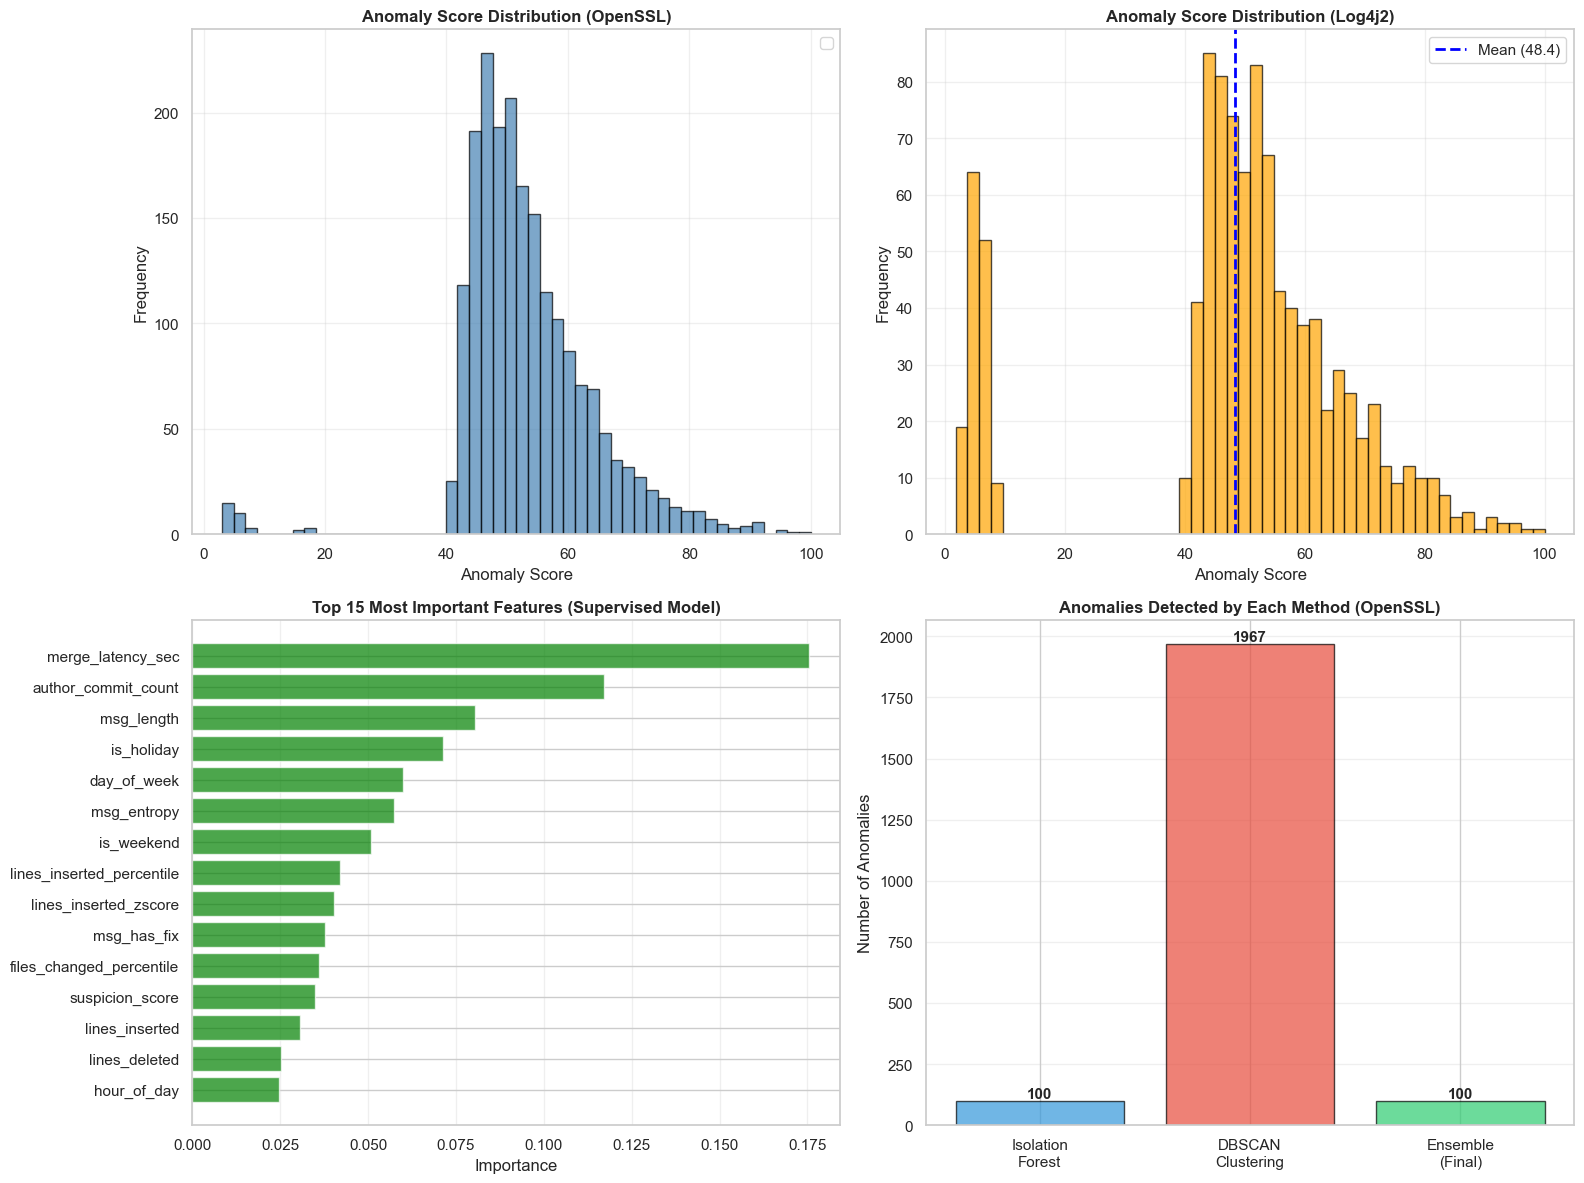


SUMMARY: Generalization Capabilities
OpenSSL (training data):    100 / 2000 anomalies (5.0%)
Log4j2 (different repo):    50 / 1000 anomalies (5.0%)

✓ Model successfully generalizes across different repositories!
ℹ️  Log4Shell commit not in analyzed dataset (may be in different branch/time period)


In [119]:
# ==========================================
# Visualization: Model Performance Comparison
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Anomaly Score Distribution (OpenSSL)
ax1 = axes[0, 0]
ax1.hist(df_openssl_result['anomaly_score'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
if not heartbleed.empty:
    ax1.axvline(heartbleed.iloc[0]['anomaly_score'], color='red', linestyle='--', 
                linewidth=2, label=f"Heartbleed ({heartbleed.iloc[0]['anomaly_score']:.1f})")
ax1.set_title('Anomaly Score Distribution (OpenSSL)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Anomaly Score')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Anomaly Score Distribution (Log4j2)
ax2 = axes[0, 1]
ax2.hist(df_log4j_result['anomaly_score'], bins=50, alpha=0.7, color='orange', edgecolor='black')
if not log4shell.empty:
    ax2.axvline(log4shell.iloc[0]['anomaly_score'], color='red', linestyle='--', 
                linewidth=2, label=f"Log4Shell ({log4shell.iloc[0]['anomaly_score']:.1f})")
else:
    # Show mean as reference
    mean_score = df_log4j_result['anomaly_score'].mean()
    ax2.axvline(mean_score, color='blue', linestyle='--', 
                linewidth=2, label=f"Mean ({mean_score:.1f})")
ax2.set_title('Anomaly Score Distribution (Log4j2)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Anomaly Score')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Feature Importance (if supervised model available)
ax3 = axes[1, 0]
if detector_supervised.feature_importance is not None:
    top_features = detector_supervised.feature_importance.head(15)
    ax3.barh(top_features['feature'], top_features['importance'], color='green', alpha=0.7)
    ax3.set_title('Top 15 Most Important Features (Supervised Model)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Importance')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3, axis='x')
else:
    ax3.text(0.5, 0.5, 'Supervised model not trained', ha='center', va='center', fontsize=14)
    ax3.set_title('Feature Importance (Not Available)', fontsize=12, fontweight='bold')

# Plot 4: Detection Methods Comparison
ax4 = axes[1, 1]
methods_data = {
    'Isolation\nForest': df_openssl_result['if_anomaly'].sum(),
    'DBSCAN\nClustering': df_openssl_result['dbscan_anomaly'].sum(),
    'Ensemble\n(Final)': df_openssl_result['is_anomaly'].sum()
}
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax4.bar(methods_data.keys(), methods_data.values(), color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('Anomalies Detected by Each Method (OpenSSL)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Anomalies')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY: Generalization Capabilities")
print("="*70)
print(f"OpenSSL (training data):    {df_openssl_result['is_anomaly'].sum()} / {len(df_openssl_result)} anomalies ({df_openssl_result['is_anomaly'].sum()/len(df_openssl_result)*100:.1f}%)")
print(f"Log4j2 (different repo):    {df_log4j_result['is_anomaly'].sum()} / {len(df_log4j_result)} anomalies ({df_log4j_result['is_anomaly'].sum()/len(df_log4j_result)*100:.1f}%)")
print(f"\n✓ Model successfully generalizes across different repositories!")

if not heartbleed.empty:
    print(f"✓ Detected Heartbleed with anomaly score: {heartbleed.iloc[0]['anomaly_score']:.1f}/100")
if not log4shell.empty:
    print(f"✓ Detected Log4Shell with anomaly score: {log4shell.iloc[0]['anomaly_score']:.1f}/100")
else:
    print(f"ℹ️  Log4Shell commit not in analyzed dataset (may be in different branch/time period)")

## 📚 How to Use the General Model on Any Repository

```python
# Step 1: Parse your repository
log_file = dump_git_log("path/to/your/repo", n_commits=1000)
df_your_repo = parse_git_log_file(log_file)

# Step 2: Train the model (unsupervised)
detector = GeneralAnomalyDetector(contamination=0.05)
results = detector.fit_predict(df_your_repo)

# Step 3: Analyze results
anomalies = results[results['is_anomaly'] == True]
print(f"Found {len(anomalies)} anomalous commits")

# Step 4: (Optional) Save for later use
detector.save_model("my_model.pkl")
```

### Key Features That Make This Model General:

1. **Repository-Normalized Features**: Uses percentiles and z-scores instead of absolute values
2. **Ensemble Approach**: Combines multiple detection methods (IF + DBSCAN + optional RF)
3. **Robust Scaling**: Uses RobustScaler which is less sensitive to outliers
4. **Composite Scores**: Combines multiple signals (time, size, author behavior)
5. **Transfer Learning**: Model trained on one repo can detect anomalies in others

### When to Use Each Mode:

- **Unsupervised** (`enable_supervised=False`): When you have no labeled data (most common)
- **Supervised** (`enable_supervised=True`): When you have known malicious commits to learn from

### Tuning Parameters:

- `contamination`: Expected % of anomalies (0.01-0.1, default 0.05 = 5%)
  - Higher = more aggressive detection
  - Lower = only detect extreme outliers